In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # to separate pages based on language (regular expression)
import matplotlib.pyplot as plt
import math

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


# Importing the Keras libraries and packages for LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout #prevent overfitting


import seaborn as sns
sns.set()
import os

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# train = pd.read_csv('/content/train_2.csv').fillna(0)
train = pd.read_csv('/content/drive/MyDrive/5002project/train_2.csv').fillna(0)
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,46.0,24.0,22.0,22.0,11.0,25.0,45.0,39.0,17.0,18.0,13.0,57.0,18.0,14.0,19.0,39.0,22.0,16.0,28.0,21.0,37.0,58.0,25.0,23.0,25.0,47.0,44.0,26.0,24.0,21.0,19.0,33.0,33.0,18.0,16.0,27.0,29.0,23.0,54.0,38.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,39.0,20.0,31.0,19.0,7.0,11.0,20.0,13.0,16.0,16.0,47.0,21.0,20.0,12.0,13.0,20.0,22.0,20.0,12.0,37.0,14.0,34.0,16.0,31.0,34.0,33.0,32.0,29.0,34.0,25.0,32.0,30.0,11.0,19.0,54.0,25.0,26.0,23.0,13.0,81.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,22.0,8.0,4.0,3.0,1.0,3.0,7.0,3.0,1.0,9.0,4.0,2.0,6.0,3.0,3.0,3.0,8.0,2.0,4.0,3.0,6.0,23.0,11.0,8.0,6.0,13.0,12.0,8.0,12.0,9.0,6.0,6.0,7.0,2.0,4.0,7.0,3.0,4.0,7.0,6.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,37.0,14.0,12.0,13.0,11.0,10.0,14.0,15.0,15.0,11.0,19.0,9.0,19.0,8.0,17.0,11.0,18.0,20.0,11.0,11.0,21.0,42.0,23.0,17.0,11.0,21.0,20.0,20.0,110.0,15.0,7.0,19.0,19.0,9.0,6.0,16.0,19.0,30.0,38.0,4.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,39.0,66.0,114.0,19.0,29.0,12.0,11.0,14.0,14.0,63.0,12.0,22.0,14.0,20.0,11.0,23.0,66.0,19.0,23.0,23.0,41.0,25.0,22.0,20.0,24.0,29.0,20.0,17.0,24.0,16.0,16.0,19.0,9.0,20.0,23.0,28.0,14.0,8.0,7.0


In [ ]:
# Commented out for now to stop errors with some of the statsmodels methods
for col in train.columns[1:]:
   train[col] = pd.to_numeric(train[col],downcast='integer')
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,9,22,26,24,19,10,14,15,8,16,8,8,16,7,11,10,20,18,15,14,49,10,16,18,8,5,9,7,13,9,7,4,11,...,46,24,22,22,11,25,45,39,17,18,13,57,18,14,19,39,22,16,28,21,37,58,25,23,25,47,44,26,24,21,19,33,33,18,16,27,29,23,54,38
1,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,13,22,11,10,4,41,65,57,38,20,62,44,15,10,47,24,17,22,9,39,13,11,12,21,19,9,15,33,8,8,7,13,2,23,...,39,20,31,19,7,11,20,13,16,16,47,21,20,12,13,20,22,20,12,37,14,34,16,31,34,33,32,29,34,25,32,30,11,19,54,25,26,23,13,81
2,3C_zh.wikipedia.org_all-access_spider,1,0,1,1,0,4,0,3,4,4,1,1,1,6,8,6,4,5,1,2,3,8,8,6,6,2,2,3,2,4,3,3,5,3,5,4,2,5,1,...,22,8,4,3,1,3,7,3,1,9,4,2,6,3,3,3,8,2,4,3,6,23,11,8,6,13,12,8,12,9,6,6,7,2,4,7,3,4,7,6
3,4minute_zh.wikipedia.org_all-access_spider,35,13,10,94,4,26,14,9,11,16,16,11,23,145,14,17,85,4,30,22,9,10,11,7,7,11,9,11,44,8,14,19,10,17,17,10,7,10,1,...,37,14,12,13,11,10,14,15,15,11,19,9,19,8,17,11,18,20,11,11,21,42,23,17,11,21,20,20,110,15,7,19,19,9,6,16,19,30,38,4
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,40,39,66,114,19,29,12,11,14,14,63,12,22,14,20,11,23,66,19,23,23,41,25,22,20,24,29,20,17,24,16,16,19,9,20,23,28,14,8,7


In [ ]:
train_flattened = pd.melt(train[list(train.columns[2:])+['Page']], id_vars='Page', var_name='date', value_name='Visits')
train_flattened['date'] = train_flattened['date'].astype('datetime64[ns]')
train_flattened.head()

,Page,date,Visits
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-02,11
1,2PM_zh.wikipedia.org_all-access_spider,2015-07-02,14
2,3C_zh.wikipedia.org_all-access_spider,2015-07-02,0
3,4minute_zh.wikipedia.org_all-access_spider,2015-07-02,13
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,2015-07-02,0


# 特征提取

In [ ]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

train['lang'] = train.Page.map(get_language)

from collections import Counter

print(Counter(train.lang))

Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'na': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


In [ ]:
lang_sets = {}
lang_sets['en'] = train[train.lang=='en'].iloc[:,0:-1]
lang_sets['ja'] = train[train.lang=='ja'].iloc[:,0:-1]
lang_sets['de'] = train[train.lang=='de'].iloc[:,0:-1]
lang_sets['na'] = train[train.lang=='na'].iloc[:,0:-1]
lang_sets['fr'] = train[train.lang=='fr'].iloc[:,0:-1]
lang_sets['zh'] = train[train.lang=='zh'].iloc[:,0:-1]
lang_sets['ru'] = train[train.lang=='ru'].iloc[:,0:-1]
lang_sets['es'] = train[train.lang=='es'].iloc[:,0:-1]

sums = {}
for key in lang_sets:
    sums[key] = lang_sets[key].iloc[:,1:].sum(axis=0) / lang_sets[key].shape[0]

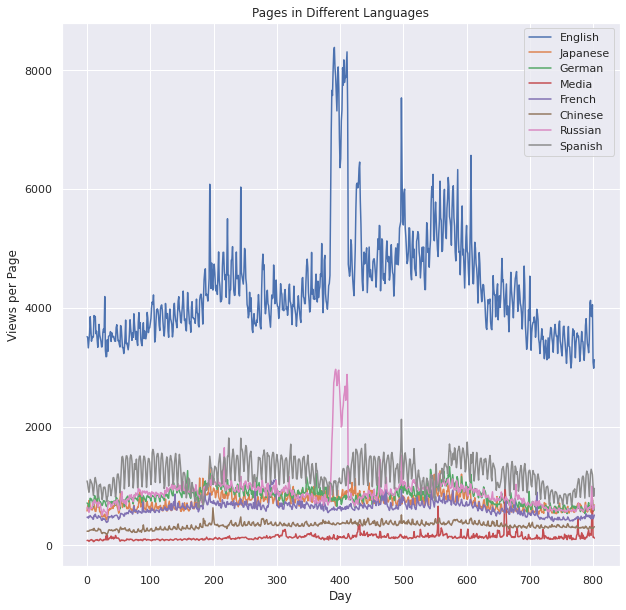

In [ ]:
days = [r for r in range(sums['en'].shape[0])]

fig = plt.figure(1,figsize=[10,10])
plt.ylabel('Views per Page')
plt.xlabel('Day')
plt.title('Pages in Different Languages')
labels={'en':'English','ja':'Japanese','de':'German',
        'na':'Media','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'
       }

for key in sums:
    plt.plot(days,sums[key],label = labels[key] )
    
plt.legend()
plt.show()

In [ ]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,lang
0,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,9,22,26,24,19,10,14,15,8,16,8,8,16,7,11,10,20,18,15,14,49,10,16,18,8,5,9,7,13,9,7,4,11,...,24,22,22,11,25,45,39,17,18,13,57,18,14,19,39,22,16,28,21,37,58,25,23,25,47,44,26,24,21,19,33,33,18,16,27,29,23,54,38,zh
1,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,13,22,11,10,4,41,65,57,38,20,62,44,15,10,47,24,17,22,9,39,13,11,12,21,19,9,15,33,8,8,7,13,2,23,...,20,31,19,7,11,20,13,16,16,47,21,20,12,13,20,22,20,12,37,14,34,16,31,34,33,32,29,34,25,32,30,11,19,54,25,26,23,13,81,zh
2,3C_zh.wikipedia.org_all-access_spider,1,0,1,1,0,4,0,3,4,4,1,1,1,6,8,6,4,5,1,2,3,8,8,6,6,2,2,3,2,4,3,3,5,3,5,4,2,5,1,...,8,4,3,1,3,7,3,1,9,4,2,6,3,3,3,8,2,4,3,6,23,11,8,6,13,12,8,12,9,6,6,7,2,4,7,3,4,7,6,zh
3,4minute_zh.wikipedia.org_all-access_spider,35,13,10,94,4,26,14,9,11,16,16,11,23,145,14,17,85,4,30,22,9,10,11,7,7,11,9,11,44,8,14,19,10,17,17,10,7,10,1,...,14,12,13,11,10,14,15,15,11,19,9,19,8,17,11,18,20,11,11,21,42,23,17,11,21,20,20,110,15,7,19,19,9,6,16,19,30,38,4,zh
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,39,66,114,19,29,12,11,14,14,63,12,22,14,20,11,23,66,19,23,23,41,25,22,20,24,29,20,17,24,16,16,19,9,20,23,28,14,8,7,zh


# ARIMA

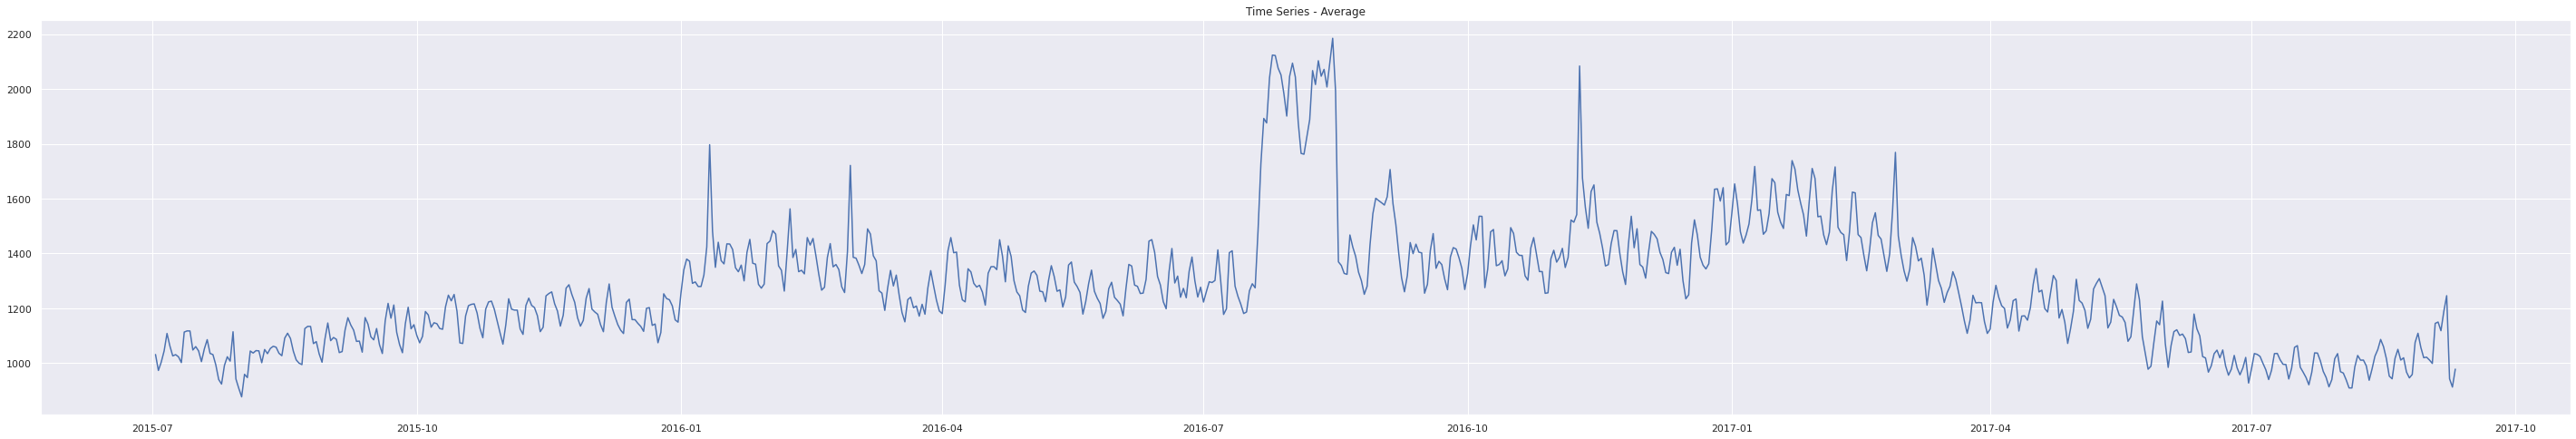

In [ ]:
plt.figure(figsize=(50, 8))
mean_group = train_flattened[['Page','date','Visits']].groupby(['date'])['Visits'].mean()
plt.plot(mean_group)
plt.title('Time Series - Average')
plt.show()

In [ ]:
times_series_means =  pd.DataFrame(mean_group).reset_index(drop=False)
times_series_means.head()

,date,Visits
0,2015-07-02,1031.233602
1,2015-07-03,973.123388
2,2015-07-04,1003.791022
3,2015-07-05,1044.341920
4,2015-07-06,1108.085687


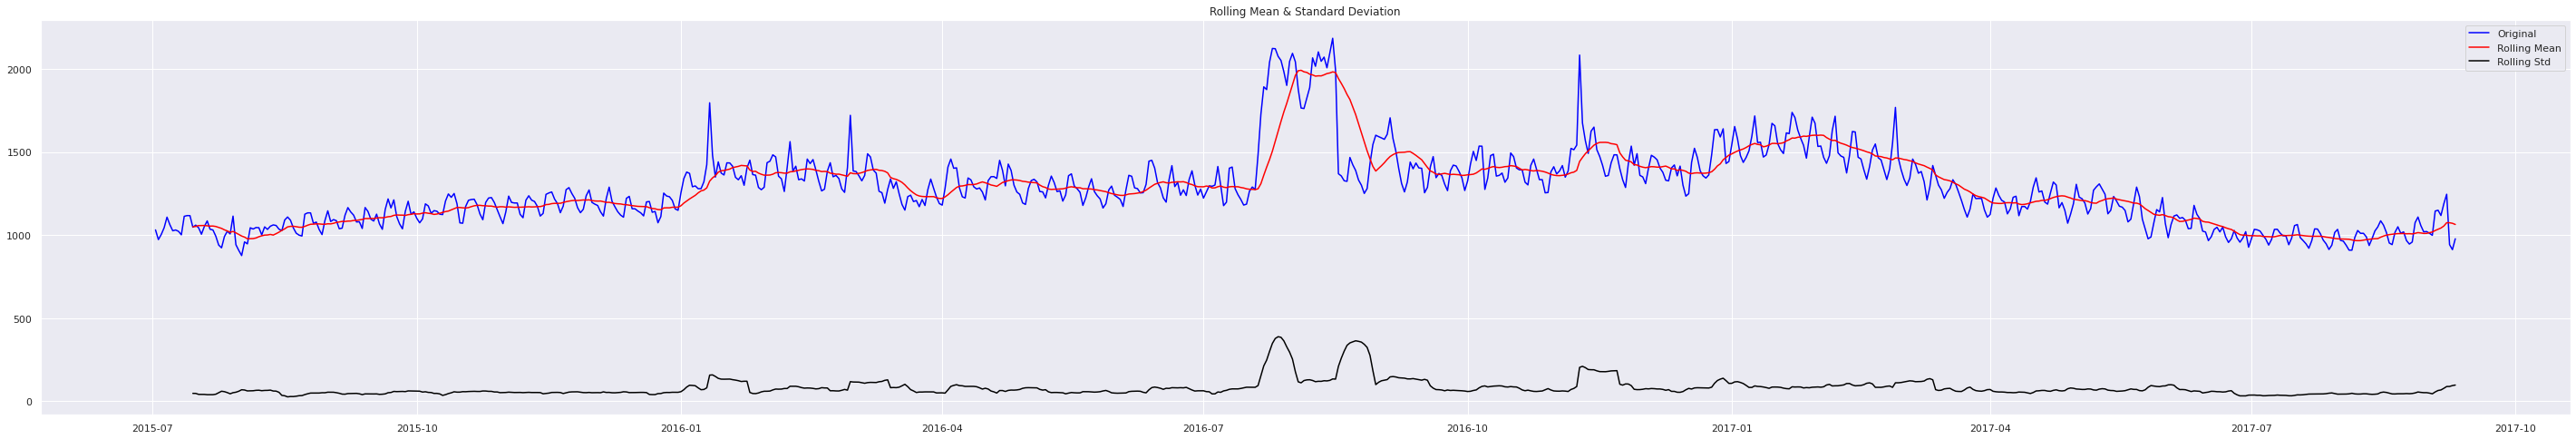

Results of Dickey-Fuller Test:
Test Statistic                  -2.679738
p-value                          0.077611
#Lags Used                      21.000000
Number of Observations Used    780.000000
Critical Value (1%)             -3.438761
Critical Value (5%)             -2.865253
Critical Value (10%)            -2.568747
dtype: float64


In [ ]:
# Show Rolling mean, Rolling Std and Test for the stationnarity
df_date_index = times_series_means[['date','Visits']].set_index('date')

def test_stationarity(timeseries):
    plt.figure(figsize=(50, 8))
    #Determing rolling statistics
#     rolmean = pd.rolling_mean(timeseries, window=7)
#     rolstd = pd.rolling_std(timeseries, window=7)
    rolmean = timeseries.rolling(window=14).mean()
    rolstd = timeseries.rolling(window=14).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = sm.tsa.adfuller(timeseries['Visits'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(df_date_index)   

In [ ]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10,lang
0,2NE1_zh.wikipedia.org_all-access_spider,18,11,5,13,14,9,9,22,26,24,19,10,14,15,8,16,8,8,16,7,11,10,20,18,15,14,49,10,16,18,8,5,9,7,13,9,7,4,11,...,24,22,22,11,25,45,39,17,18,13,57,18,14,19,39,22,16,28,21,37,58,25,23,25,47,44,26,24,21,19,33,33,18,16,27,29,23,54,38,zh
1,2PM_zh.wikipedia.org_all-access_spider,11,14,15,18,11,13,22,11,10,4,41,65,57,38,20,62,44,15,10,47,24,17,22,9,39,13,11,12,21,19,9,15,33,8,8,7,13,2,23,...,20,31,19,7,11,20,13,16,16,47,21,20,12,13,20,22,20,12,37,14,34,16,31,34,33,32,29,34,25,32,30,11,19,54,25,26,23,13,81,zh
2,3C_zh.wikipedia.org_all-access_spider,1,0,1,1,0,4,0,3,4,4,1,1,1,6,8,6,4,5,1,2,3,8,8,6,6,2,2,3,2,4,3,3,5,3,5,4,2,5,1,...,8,4,3,1,3,7,3,1,9,4,2,6,3,3,3,8,2,4,3,6,23,11,8,6,13,12,8,12,9,6,6,7,2,4,7,3,4,7,6,zh
3,4minute_zh.wikipedia.org_all-access_spider,35,13,10,94,4,26,14,9,11,16,16,11,23,145,14,17,85,4,30,22,9,10,11,7,7,11,9,11,44,8,14,19,10,17,17,10,7,10,1,...,14,12,13,11,10,14,15,15,11,19,9,19,8,17,11,18,20,11,11,21,42,23,17,11,21,20,20,110,15,7,19,19,9,6,16,19,30,38,4,zh
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,39,66,114,19,29,12,11,14,14,63,12,22,14,20,11,23,66,19,23,23,41,25,22,20,24,29,20,17,24,16,16,19,9,20,23,28,14,8,7,zh


In [ ]:
colls = train.columns.values

# languages distinguished
cols = ['Page']*len(colls)
cols[1] = 'lang'
cols[2:] = colls[1:-1]
train = train[cols]

# non-languages
# train = train[colls[:-1]]

train.head()

,Page,lang,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,...,2017-08-02,2017-08-03,2017-08-04,2017-08-05,2017-08-06,2017-08-07,2017-08-08,2017-08-09,2017-08-10,2017-08-11,2017-08-12,2017-08-13,2017-08-14,2017-08-15,2017-08-16,2017-08-17,2017-08-18,2017-08-19,2017-08-20,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-26,2017-08-27,2017-08-28,2017-08-29,2017-08-30,2017-08-31,2017-09-01,2017-09-02,2017-09-03,2017-09-04,2017-09-05,2017-09-06,2017-09-07,2017-09-08,2017-09-09,2017-09-10
0,2NE1_zh.wikipedia.org_all-access_spider,zh,18,11,5,13,14,9,9,22,26,24,19,10,14,15,8,16,8,8,16,7,11,10,20,18,15,14,49,10,16,18,8,5,9,7,13,9,7,4,...,46,24,22,22,11,25,45,39,17,18,13,57,18,14,19,39,22,16,28,21,37,58,25,23,25,47,44,26,24,21,19,33,33,18,16,27,29,23,54,38
1,2PM_zh.wikipedia.org_all-access_spider,zh,11,14,15,18,11,13,22,11,10,4,41,65,57,38,20,62,44,15,10,47,24,17,22,9,39,13,11,12,21,19,9,15,33,8,8,7,13,2,...,39,20,31,19,7,11,20,13,16,16,47,21,20,12,13,20,22,20,12,37,14,34,16,31,34,33,32,29,34,25,32,30,11,19,54,25,26,23,13,81
2,3C_zh.wikipedia.org_all-access_spider,zh,1,0,1,1,0,4,0,3,4,4,1,1,1,6,8,6,4,5,1,2,3,8,8,6,6,2,2,3,2,4,3,3,5,3,5,4,2,5,...,22,8,4,3,1,3,7,3,1,9,4,2,6,3,3,3,8,2,4,3,6,23,11,8,6,13,12,8,12,9,6,6,7,2,4,7,3,4,7,6
3,4minute_zh.wikipedia.org_all-access_spider,zh,35,13,10,94,4,26,14,9,11,16,16,11,23,145,14,17,85,4,30,22,9,10,11,7,7,11,9,11,44,8,14,19,10,17,17,10,7,10,...,37,14,12,13,11,10,14,15,15,11,19,9,19,8,17,11,18,20,11,11,21,42,23,17,11,21,20,20,110,15,7,19,19,9,6,16,19,30,38,4
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,zh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,40,39,66,114,19,29,12,11,14,14,63,12,22,14,20,11,23,66,19,23,23,41,25,22,20,24,29,20,17,24,16,16,19,9,20,23,28,14,8,7


In [ ]:
# Generate train and validate dataset

def get_train_validate_set(train_df, test_percent):
    train_end = math.floor((train_df.shape[1]-5) * (1-test_percent))
    train_ds = train_df.iloc[:, np.r_[0,1,2,3,4,5:train_end]]
    test_ds = train_df.iloc[:, np.r_[0,1,2,3,4,train_end:train_df.shape[1]]]
    
    return train_ds, test_ds

X_train, y_train = get_train_validate_set(train, 0.3)

print("The training set sample:", len(X_train))
print(X_train[0:10])
print(X_train.columns)
print("The validation set sample:", len(y_train))
print(y_train[0:10])
print(y_train.columns)

The training set sample: 145063
                                                Page  ...  2017-01-08
0            2NE1_zh.wikipedia.org_all-access_spider  ...          31
1             2PM_zh.wikipedia.org_all-access_spider  ...          39
2              3C_zh.wikipedia.org_all-access_spider  ...           1
3         4minute_zh.wikipedia.org_all-access_spider  ...           5
4  52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...  ...          14
5            5566_zh.wikipedia.org_all-access_spider  ...          16
6          91Days_zh.wikipedia.org_all-access_spider  ...          13
7           A'N'D_zh.wikipedia.org_all-access_spider  ...          33
8           AKB48_zh.wikipedia.org_all-access_spider  ...          38
9           ASCII_zh.wikipedia.org_all-access_spider  ...          24

[10 rows x 559 columns]
Index(['Page', '2015-07-01', '2015-07-02', '2015-07-03', '2015-07-04',
       '2015-07-05', '2015-07-06', '2015-07-07', '2015-07-08', '2015-07-09',
       ...
       '2016-1

In [ ]:
def extract_series(df, row_num, start_idx):
    y = df.iloc[row_num, start_idx:]
    df = pd.DataFrame({ 'ds': y.index, 'y': y.values})
    return df

In [ ]:
def smape(predict, actual, debug=False):
    '''
    predict and actual is a panda series.
    In this implementation I will skip all the datapoint with actual is null
    '''
    actual = actual.fillna(0)
    data = pd.concat([predict, actual], axis=1, keys=['predict', 'actual'])
    data = data[data.actual.notnull()]
    if debug:
        print('debug', data)
    
    evals = abs(data.predict - data.actual)/(abs(data.predict) + abs(data.actual)) * 2
    evals[evals.isnull()] = 0
    #print(np.sum(evals), len(data), np.sum(evals) * 1.0 / len(data))
    
    result = np.sum(evals) / len(data)
    
    return result

In [ ]:
def rmse(predict, actual, debug=False):
    '''
    predict and actual is a panda series.
    In this implementation I will skip all the datapoint with actual is null
    '''
    actual = actual.fillna(0)
    data = pd.concat([predict, actual], axis=1, keys=['predict', 'actual'])
    data = data[data.actual.notnull()]
    if debug:
        print('debug', data)
    
    evals = metrics.mean_squared_error(data.actual, data.predict)
    
    result = np.sqrt(evals)
    
    return result

In [ ]:
from statsmodels.tsa.arima_model import ARIMA   
import warnings
from sklearn import metrics

def arima_model(df_train, df_actual, p, d, q, figSize=(12, 4), review=False):
    df_train = df_train.fillna(0)
    train_series = pd.DataFrame(df_train.y)
    train_series.index = df_train.ds
    # print(train_series)

    result = None
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        try:
            arima = ARIMA(train_series ,[p, d, q])
            result = arima.fit(disp=False)
        except Exception as e:
            print('\tARIMA failed', e)
            return 0,0
                
    #print(result.params)
    start_idx = df_train.ds[d]
    end_idx = df_actual.ds.max()
    # print(start_idx)
    # print(end_idx)
    forecast_series = result.predict(start_idx, end_idx,typ='levels')
    
    actual_series = df_actual.y
    actual_series.index = pd.to_datetime(df_actual.ds)

    if(review):
        plot_prediction_and_actual_2(train_series, forecast_series, actual_series, figSize=figSize, title='ARIMA model')
    
    return smape(forecast_series, actual_series),rmse(forecast_series, actual_series)

In [ ]:
def plot_prediction_and_actual_2(train, forecast, actual, xlim=None, ylim=None, figSize=None, title=None):
    fig, ax  = plt.subplots(1,1,figsize=figSize)
    ax.plot(pd.to_datetime(train.index), train.values, 'k.')
    ax.plot(pd.to_datetime(actual.index), actual.values, 'r.')
    ax.plot(pd.to_datetime(forecast.index), forecast.values, 'b-')
    ax.set_title(title)
    plt.show()

In [ ]:
import random
random.seed=10
ran_sample = random.sample(range(2,len(X_train)),100)

In [ ]:
print(len(X_train),len(y_train))

145063 145063


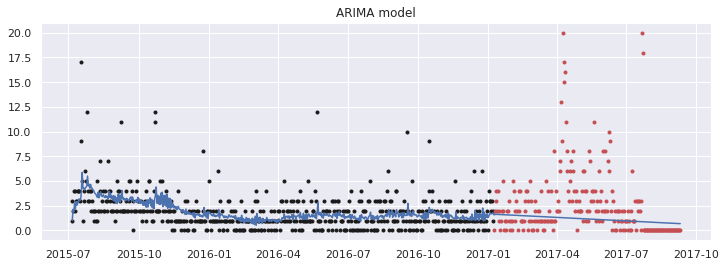

ROUND ... 112355/145063
The SMAPE score is : 1.13585
The RMSE score is : 3.62661


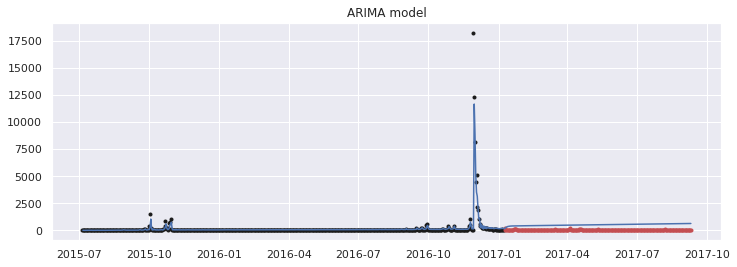

ROUND ... 72551/145063
The SMAPE score is : 1.74743
The RMSE score is : 494.86155


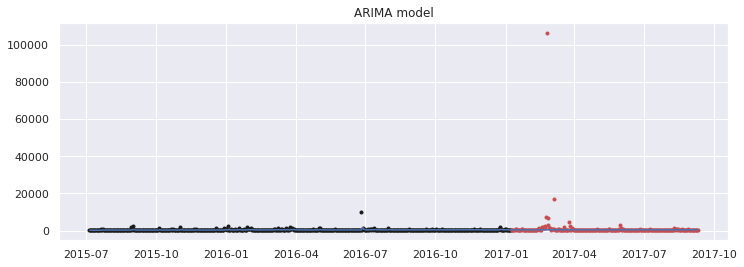

ROUND ... 95738/145063
The SMAPE score is : 0.39297
The RMSE score is : 6897.04023


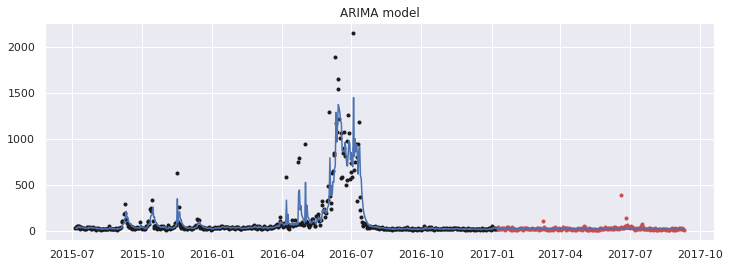

ROUND ... 69312/145063
The SMAPE score is : 0.35214
The RMSE score is : 27.76521


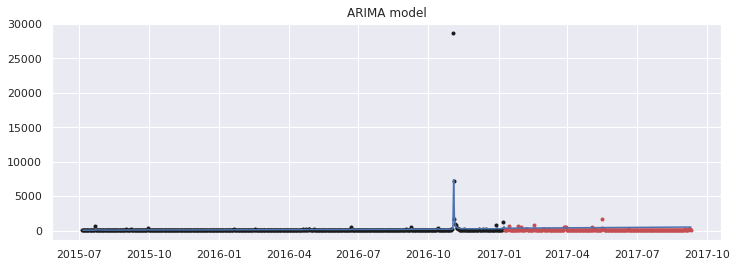

ROUND ... 25619/145063
The SMAPE score is : 1.36979
The RMSE score is : 360.81395


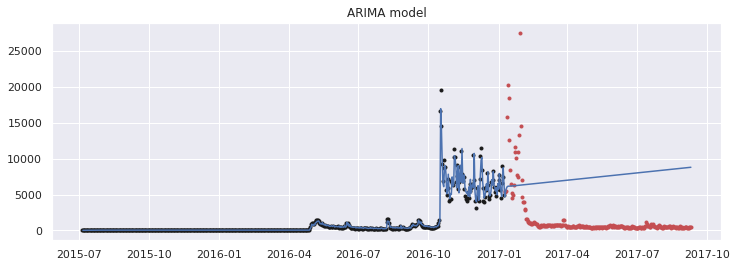

ROUND ... 76580/145063
The SMAPE score is : 1.57128
The RMSE score is : 7007.28985


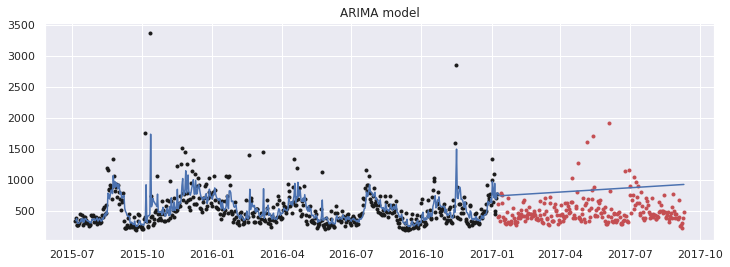

ROUND ... 52208/145063
The SMAPE score is : 0.57523
The RMSE score is : 398.80720


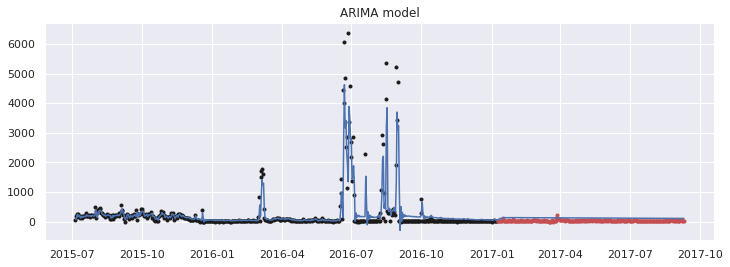

ROUND ... 6440/145063
The SMAPE score is : 1.15781
The RMSE score is : 90.19054


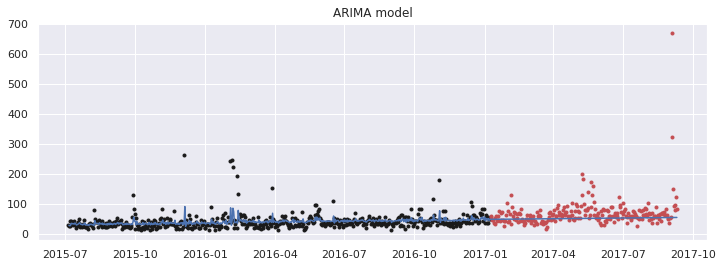

ROUND ... 80354/145063
The SMAPE score is : 0.30318
The RMSE score is : 51.57174


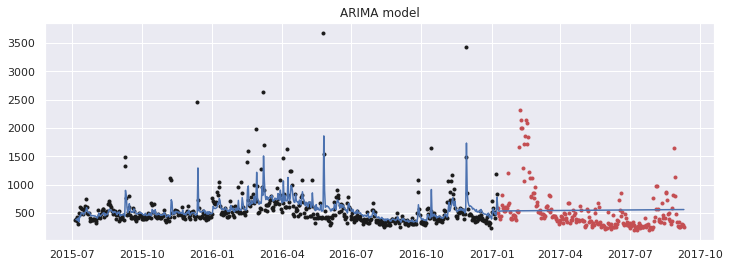

ROUND ... 103850/145063
The SMAPE score is : 0.44195
The RMSE score is : 384.72615


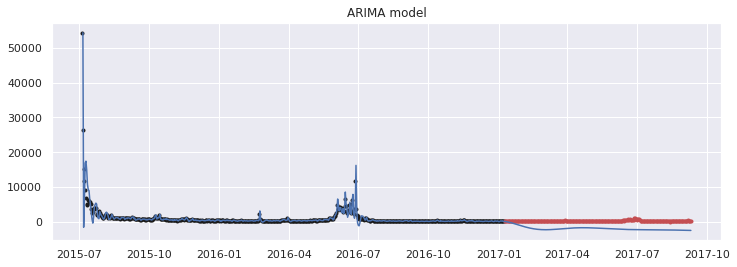

ROUND ... 72219/145063
The SMAPE score is : 1.98559
The RMSE score is : 2238.55668


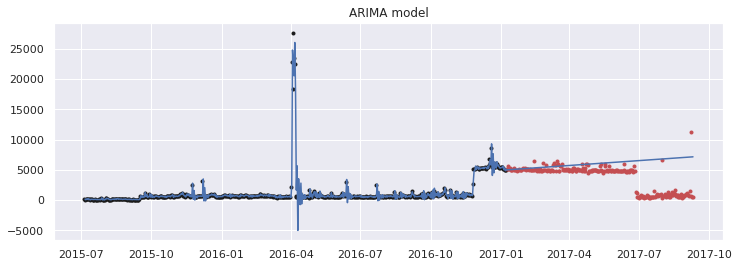

ROUND ... 36958/145063
The SMAPE score is : 0.58019
The RMSE score is : 3428.85621


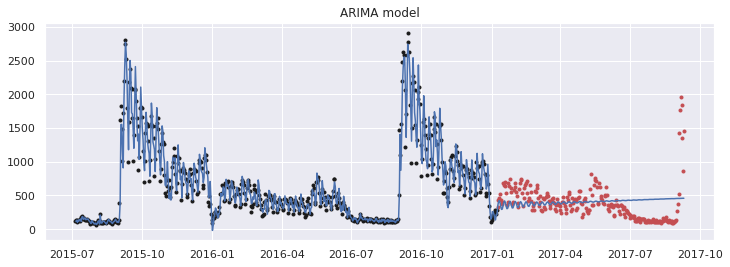

ROUND ... 17153/145063
The SMAPE score is : 0.50556
The RMSE score is : 276.85716


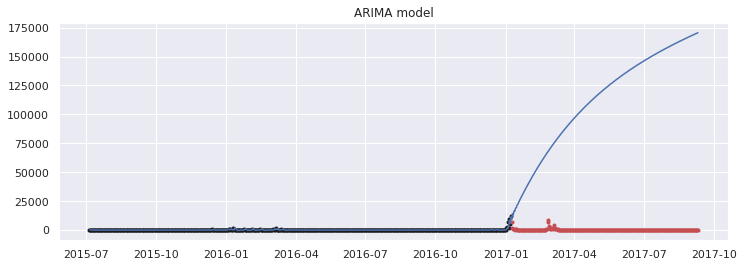

ROUND ... 101761/145063
The SMAPE score is : 1.97417
The RMSE score is : 120430.80345


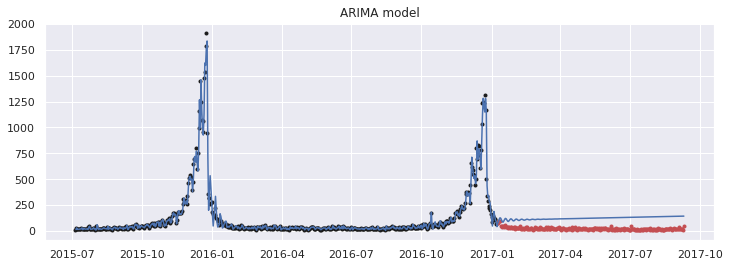

ROUND ... 6076/145063
The SMAPE score is : 1.36617
The RMSE score is : 102.30987


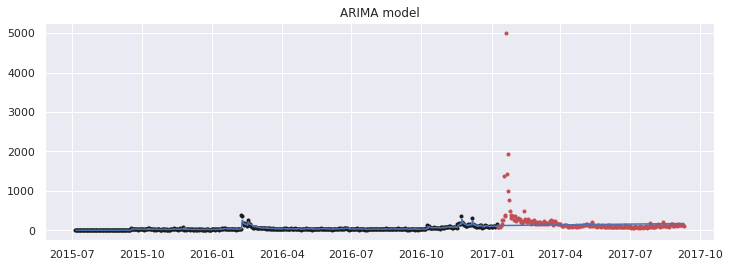

ROUND ... 136551/145063
The SMAPE score is : 0.44327
The RMSE score is : 368.30314


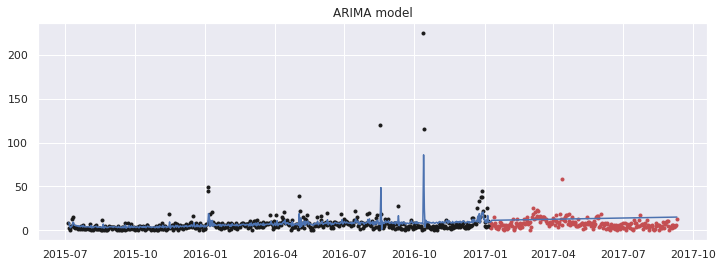

ROUND ... 130106/145063
The SMAPE score is : 0.72300
The RMSE score is : 8.13558


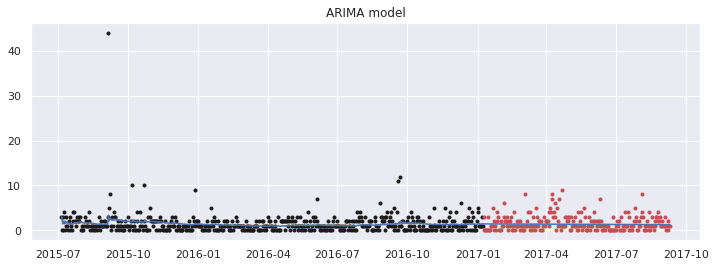

ROUND ... 111550/145063
The SMAPE score is : 0.94902
The RMSE score is : 1.74458
	ARIMA failed The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.
ROUND ... 22910/145063
The SMAPE score is : 0.00000
The RMSE score is : 0.00000
	ARIMA failed The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
ROUND ... 66823/145063
The SMAPE score is : 0.00000
The RMSE score is : 0.00000


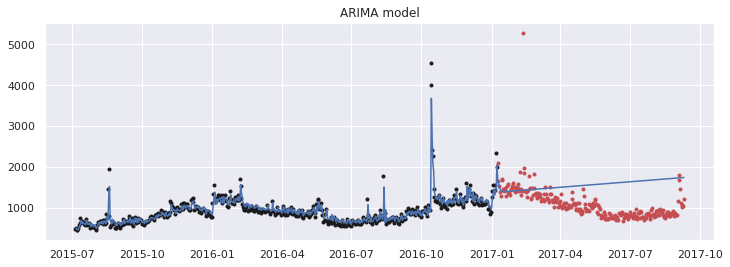

ROUND ... 17600/145063
The SMAPE score is : 0.41914
The RMSE score is : 656.95319


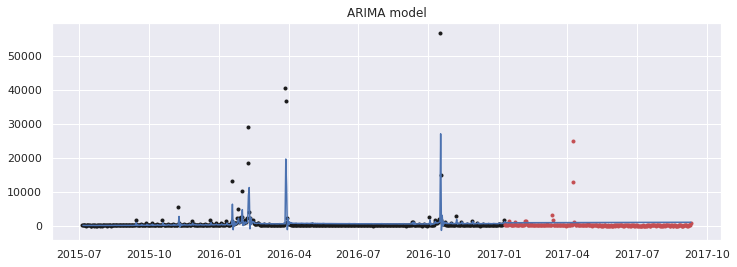

ROUND ... 115361/145063
The SMAPE score is : 1.43271
The RMSE score is : 1885.98982


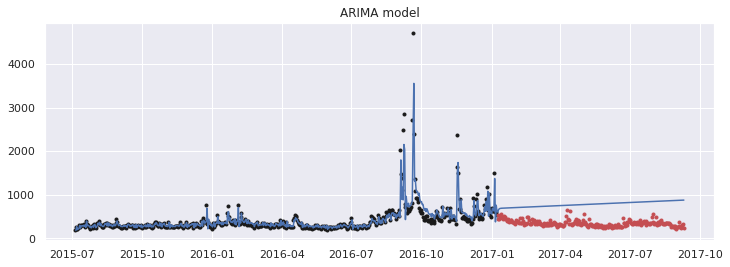

ROUND ... 102928/145063
The SMAPE score is : 0.77037
The RMSE score is : 445.40875


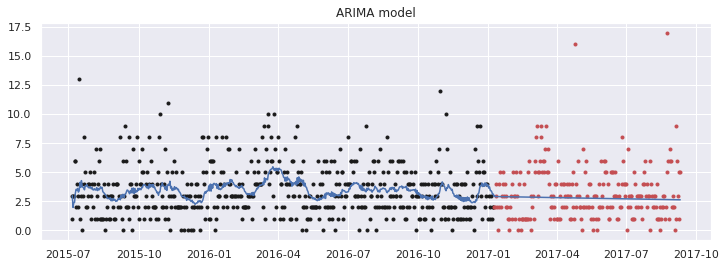

ROUND ... 13412/145063
The SMAPE score is : 0.57279
The RMSE score is : 2.33861


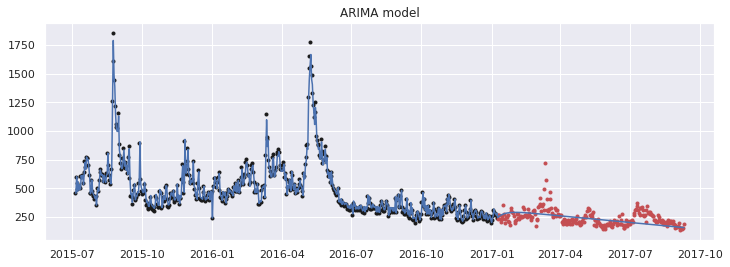

ROUND ... 101768/145063
The SMAPE score is : 0.19325
The RMSE score is : 67.76620


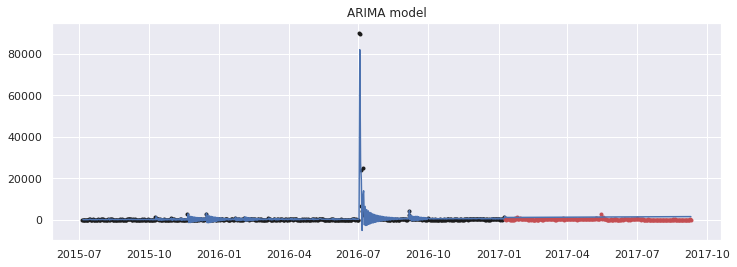

ROUND ... 52414/145063
The SMAPE score is : 1.43239
The RMSE score is : 1144.76901


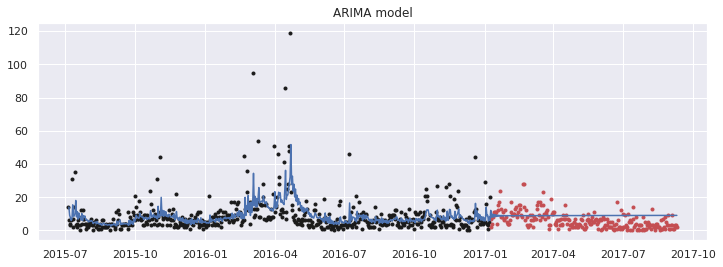

ROUND ... 144681/145063
The SMAPE score is : 0.75698
The RMSE score is : 5.75647


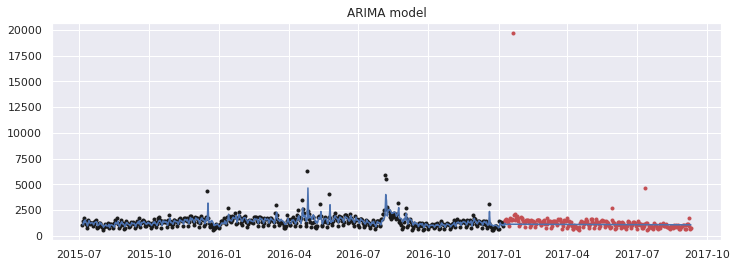

ROUND ... 65233/145063
The SMAPE score is : 0.24475
The RMSE score is : 1252.87073


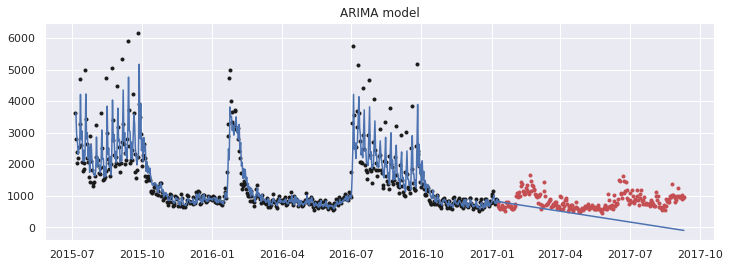

ROUND ... 61075/145063
The SMAPE score is : 0.90166
The RMSE score is : 594.29209


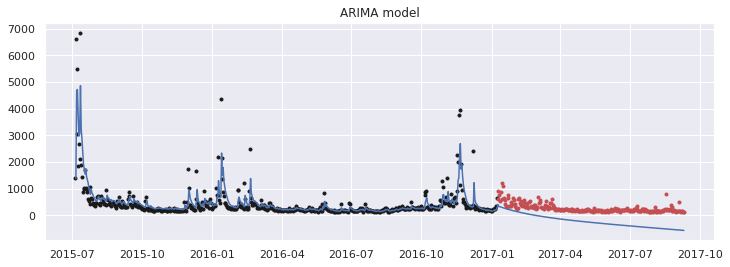

ROUND ... 88090/145063
The SMAPE score is : 1.81642
The RMSE score is : 525.51220


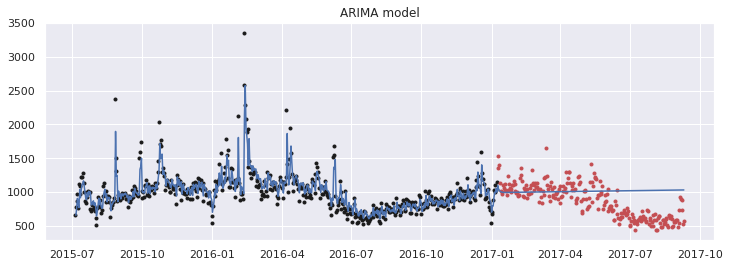

ROUND ... 104326/145063
The SMAPE score is : 0.26878
The RMSE score is : 290.57287


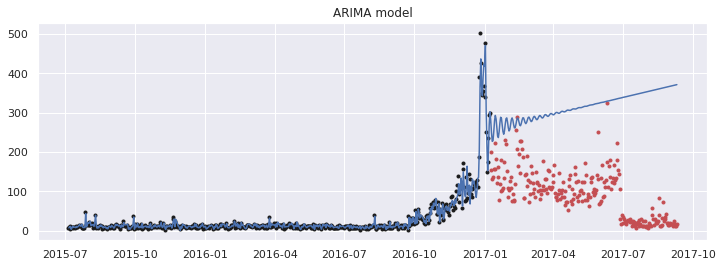

ROUND ... 45694/145063
The SMAPE score is : 1.11599
The RMSE score is : 236.68626


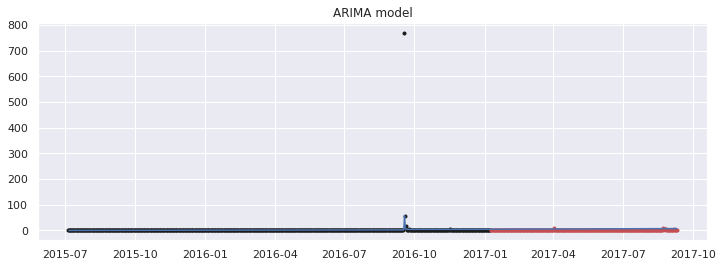

ROUND ... 21265/145063
The SMAPE score is : 1.81835
The RMSE score is : 5.58407


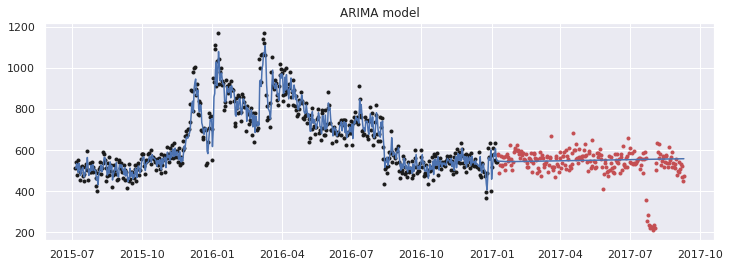

ROUND ... 43952/145063
The SMAPE score is : 0.09506
The RMSE score is : 80.03595


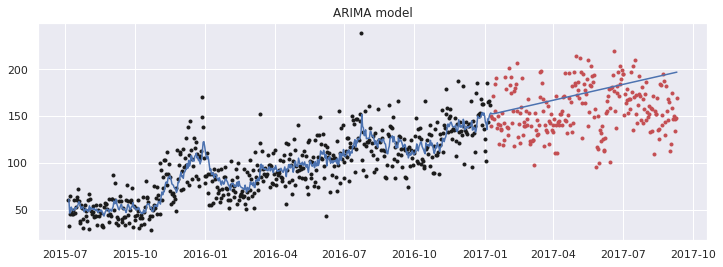

ROUND ... 77905/145063
The SMAPE score is : 0.16314
The RMSE score is : 31.95855


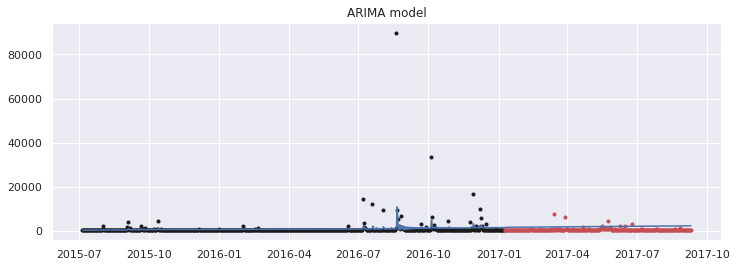

ROUND ... 57152/145063
The SMAPE score is : 1.35688
The RMSE score is : 1579.74883


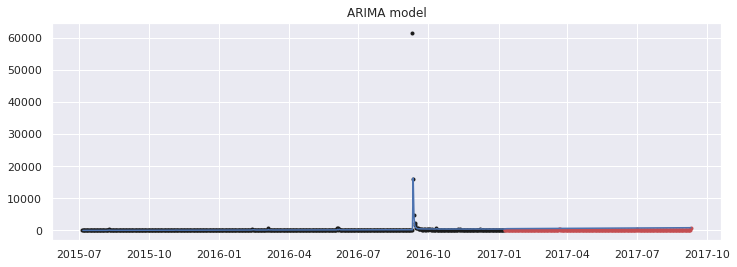

ROUND ... 18806/145063
The SMAPE score is : 1.61766
The RMSE score is : 631.43669


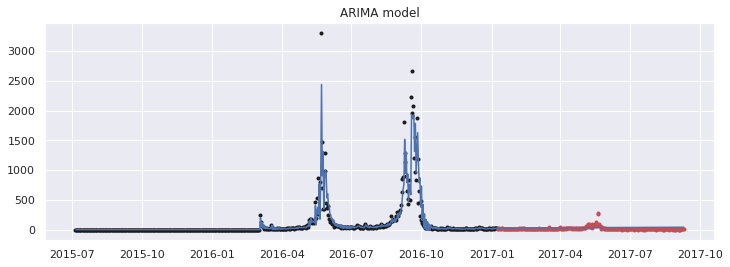

ROUND ... 19398/145063
The SMAPE score is : 1.01178
The RMSE score is : 34.49520


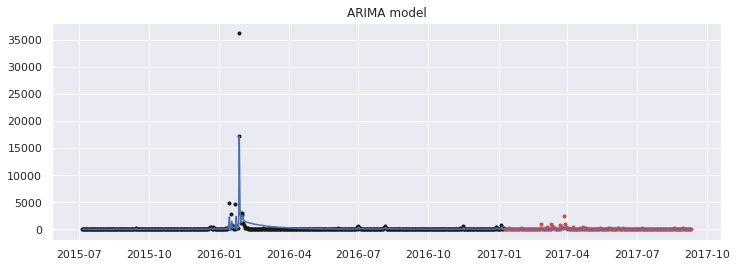

ROUND ... 57010/145063
The SMAPE score is : 0.81145
The RMSE score is : 210.59299


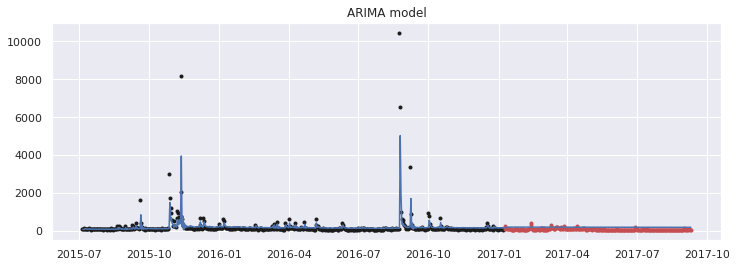

ROUND ... 67376/145063
The SMAPE score is : 0.95108
The RMSE score is : 122.07085


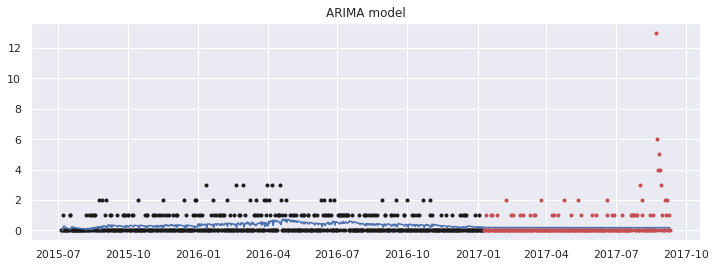

ROUND ... 15586/145063
The SMAPE score is : 1.89762
The RMSE score is : 1.14687


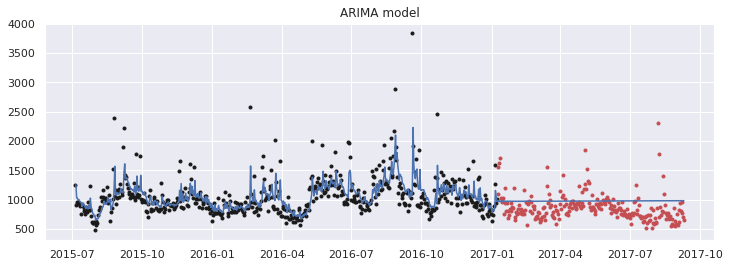

ROUND ... 85821/145063
The SMAPE score is : 0.21592
The RMSE score is : 254.05710


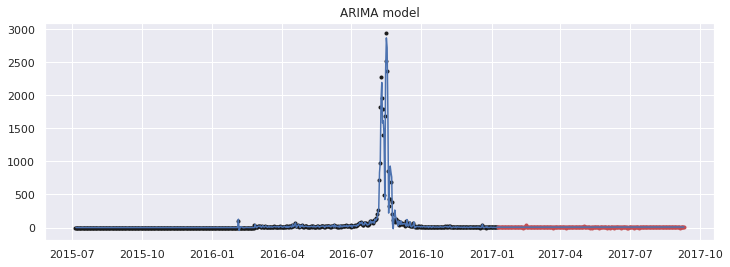

ROUND ... 69388/145063
The SMAPE score is : 0.77927
The RMSE score is : 4.62501
	ARIMA failed The computed initial MA coefficients are not invertible
You should induce invertibility, choose a different model order, or you can
pass your own start_params.
ROUND ... 54374/145063
The SMAPE score is : 0.00000
The RMSE score is : 0.00000


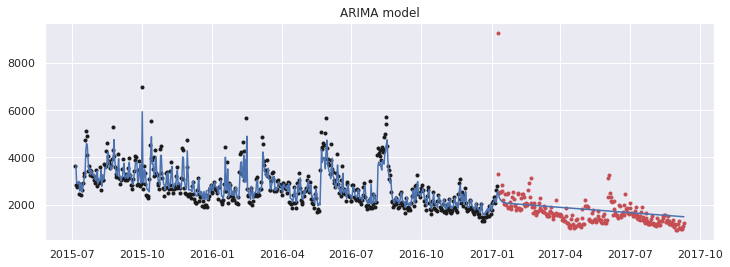

ROUND ... 55781/145063
The SMAPE score is : 0.20156
The RMSE score is : 587.46964


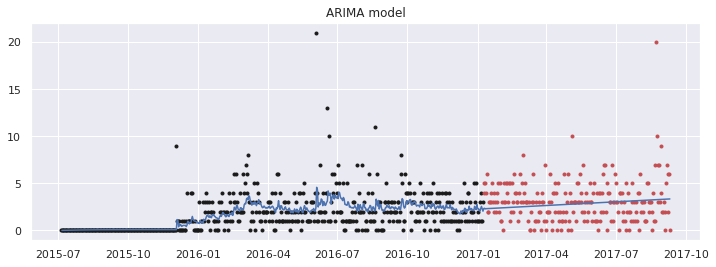

ROUND ... 14672/145063
The SMAPE score is : 0.59641
The RMSE score is : 2.25221


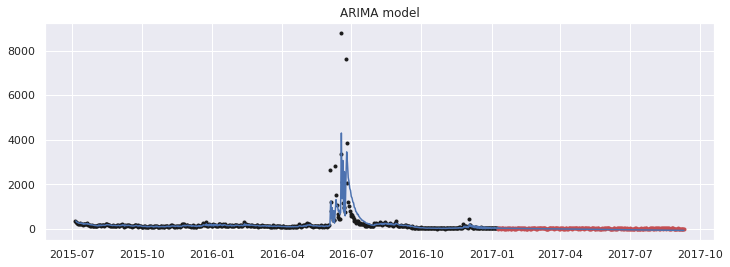

ROUND ... 56055/145063
The SMAPE score is : 1.60495
The RMSE score is : 47.08722


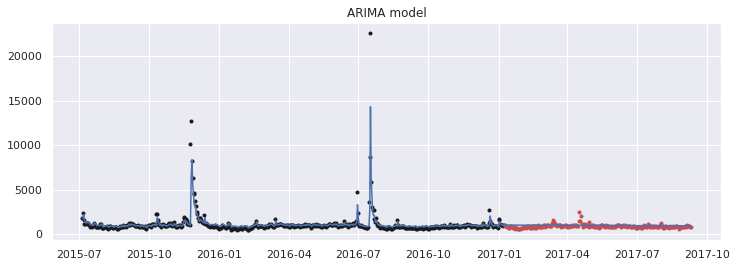

ROUND ... 28538/145063
The SMAPE score is : 0.14970
The RMSE score is : 206.09522


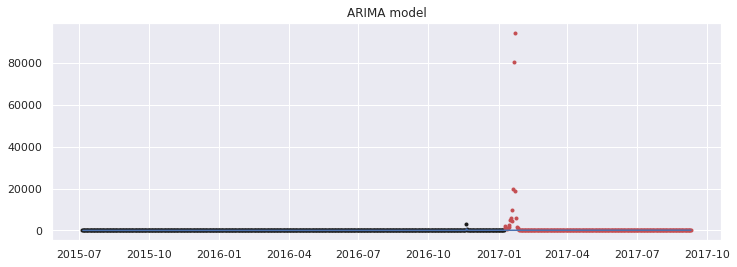

ROUND ... 77276/145063
The SMAPE score is : 1.36746
The RMSE score is : 8173.17439


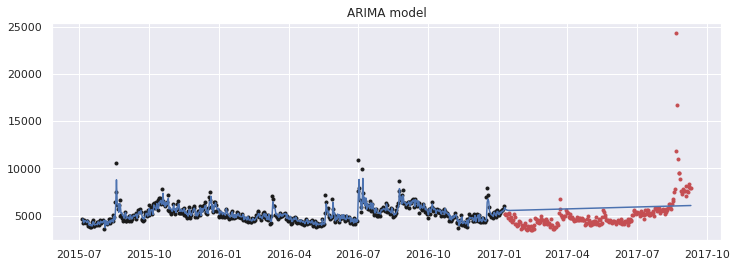

ROUND ... 72908/145063
The SMAPE score is : 0.23202
The RMSE score is : 1932.54339


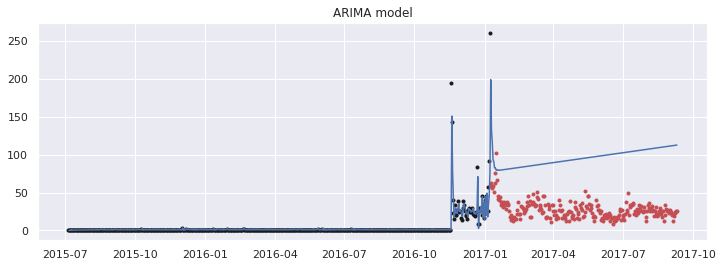

ROUND ... 127113/145063
The SMAPE score is : 1.13087
The RMSE score is : 70.99176
	ARIMA failed SVD did not converge
ROUND ... 59228/145063
The SMAPE score is : 0.00000
The RMSE score is : 0.00000


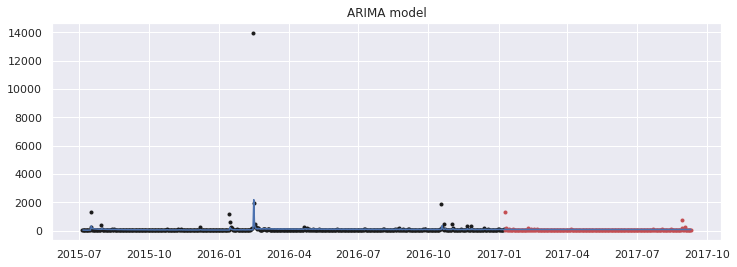

ROUND ... 52710/145063
The SMAPE score is : 0.73708
The RMSE score is : 99.03258


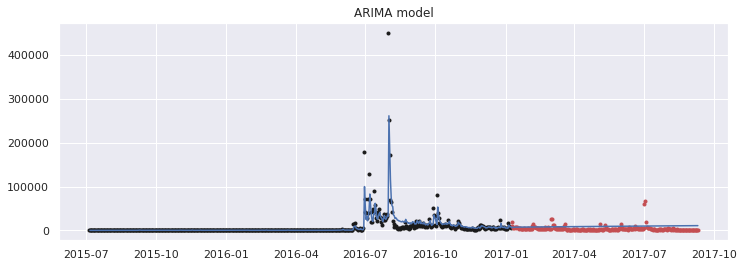

ROUND ... 119364/145063
The SMAPE score is : 1.00408
The RMSE score is : 8267.58173


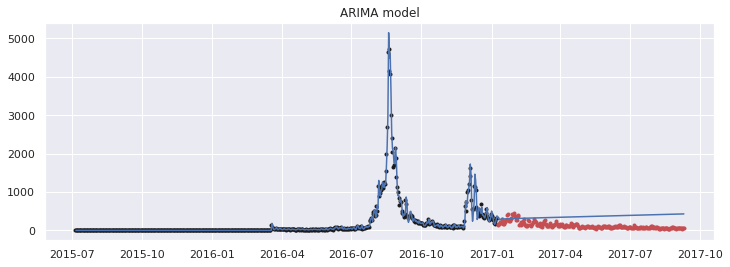

ROUND ... 31846/145063
The SMAPE score is : 1.03251
The RMSE score is : 263.10481


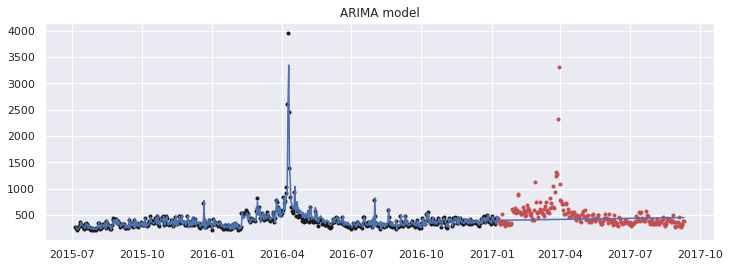

ROUND ... 30028/145063
The SMAPE score is : 0.25680
The RMSE score is : 286.68847


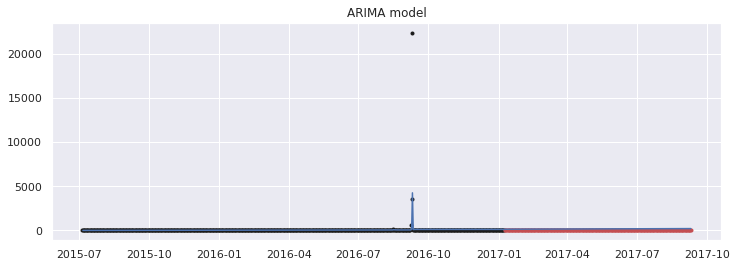

ROUND ... 65288/145063
The SMAPE score is : 1.94548
The RMSE score is : 169.59810


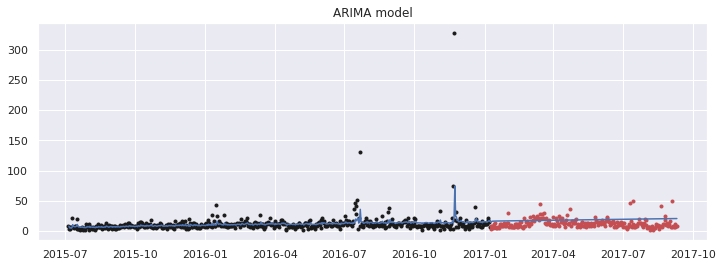

ROUND ... 50296/145063
The SMAPE score is : 0.54658
The RMSE score is : 9.39420


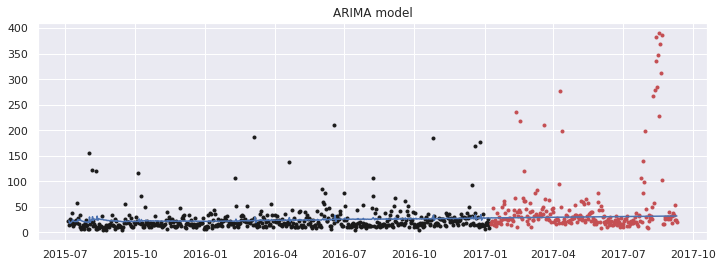

ROUND ... 141851/145063
The SMAPE score is : 0.46509
The RMSE score is : 72.65999


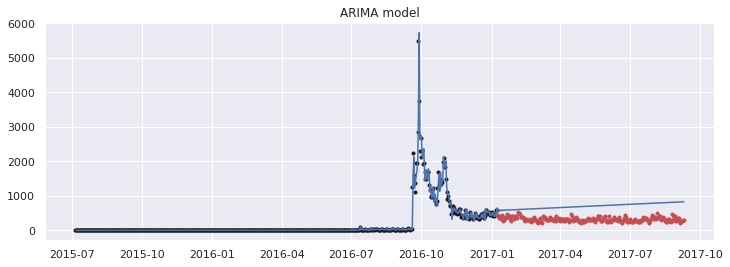

ROUND ... 31482/145063
The SMAPE score is : 0.73579
The RMSE score is : 391.87018


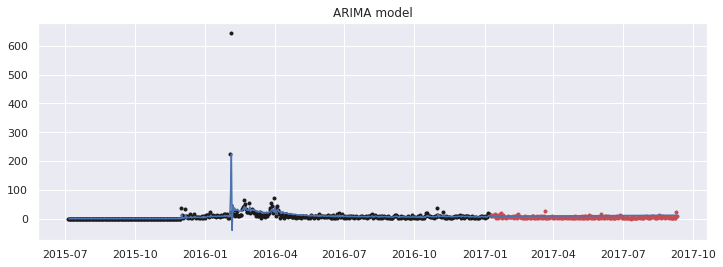

ROUND ... 127215/145063
The SMAPE score is : 0.75404
The RMSE score is : 6.32013


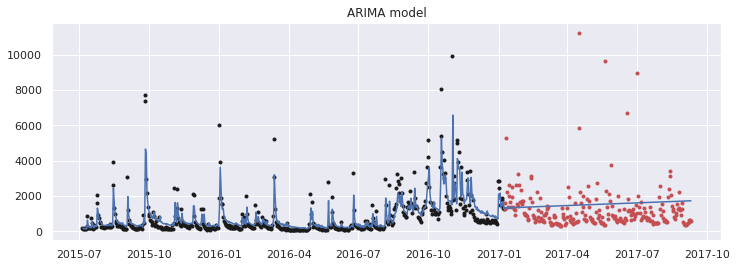

ROUND ... 85895/145063
The SMAPE score is : 0.61615
The RMSE score is : 1334.05967


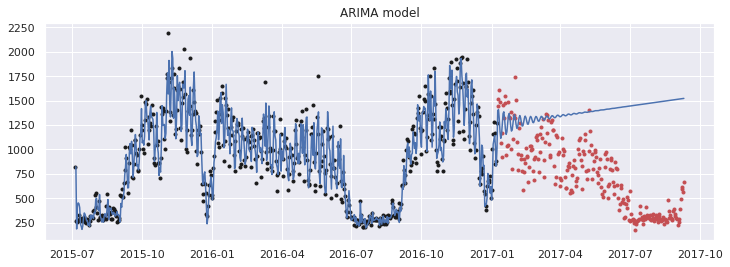

ROUND ... 25535/145063
The SMAPE score is : 0.69259
The RMSE score is : 777.59642


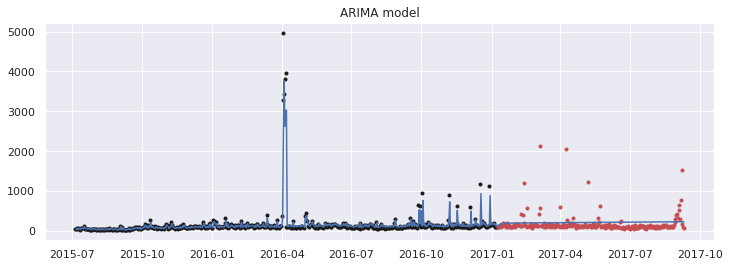

ROUND ... 36840/145063
The SMAPE score is : 0.57321
The RMSE score is : 241.70537


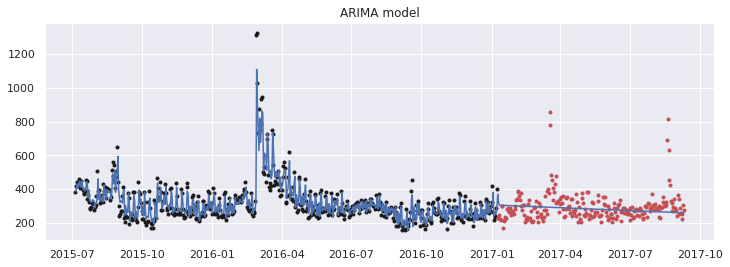

ROUND ... 107692/145063
The SMAPE score is : 0.16677
The RMSE score is : 88.81449


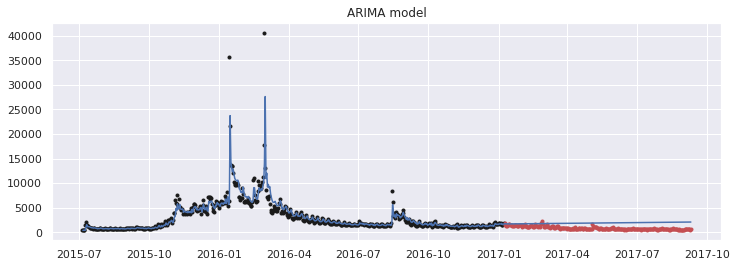

ROUND ... 11084/145063
The SMAPE score is : 0.76479
The RMSE score is : 1097.21995


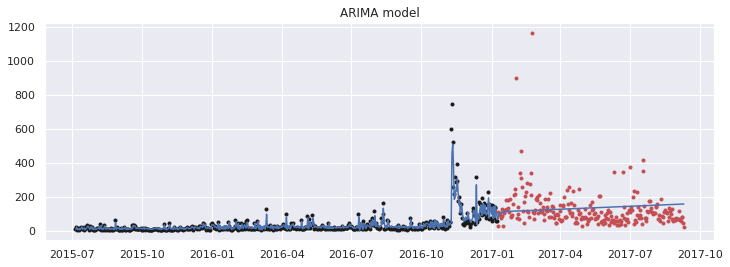

ROUND ... 35908/145063
The SMAPE score is : 0.51320
The RMSE score is : 114.51323


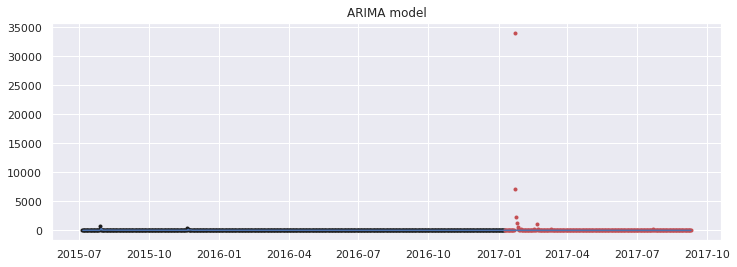

ROUND ... 29082/145063
The SMAPE score is : 1.77041
The RMSE score is : 2232.30546


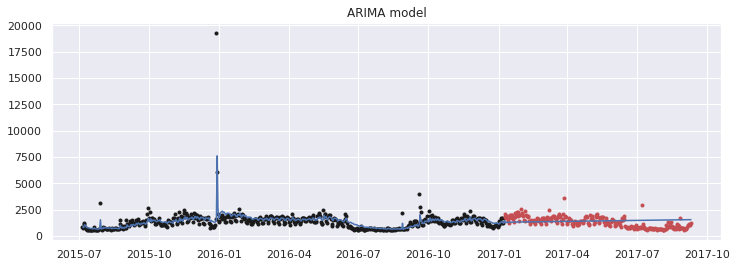

ROUND ... 24837/145063
The SMAPE score is : 0.36218
The RMSE score is : 566.04031


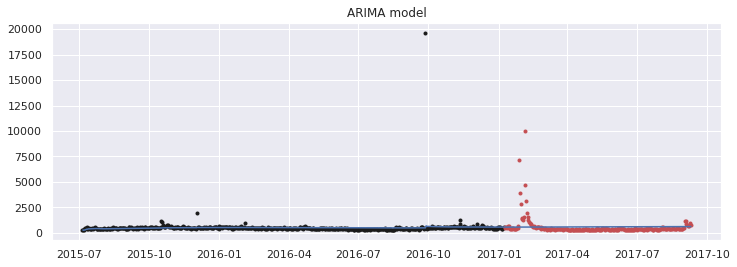

ROUND ... 101966/145063
The SMAPE score is : 0.48687
The RMSE score is : 885.05958


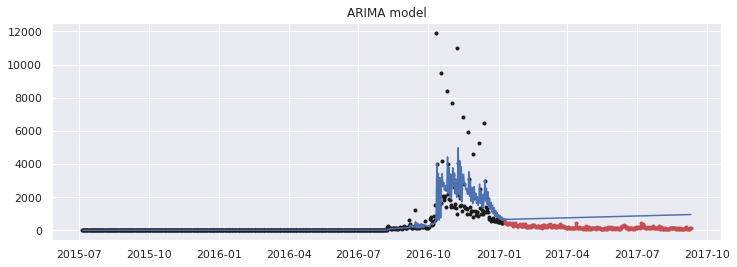

ROUND ... 60511/145063
The SMAPE score is : 1.22202
The RMSE score is : 632.42300


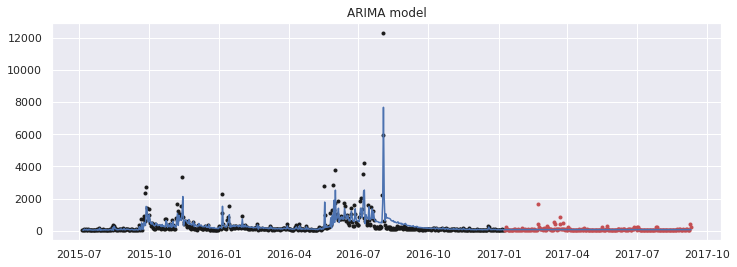

ROUND ... 69195/145063
The SMAPE score is : 0.36377
The RMSE score is : 135.99537


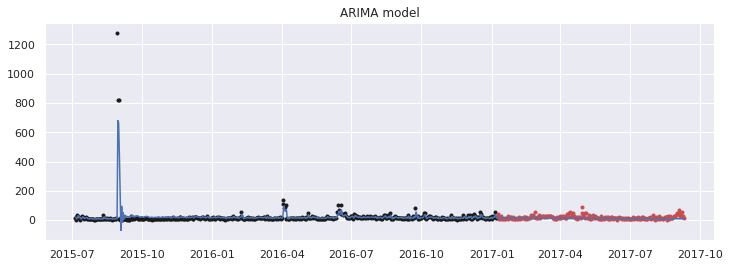

ROUND ... 35310/145063
The SMAPE score is : 0.46550
The RMSE score is : 13.59487


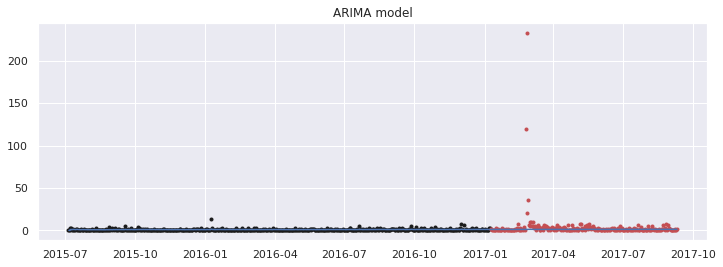

ROUND ... 134224/145063
The SMAPE score is : 0.95300
The RMSE score is : 16.93870


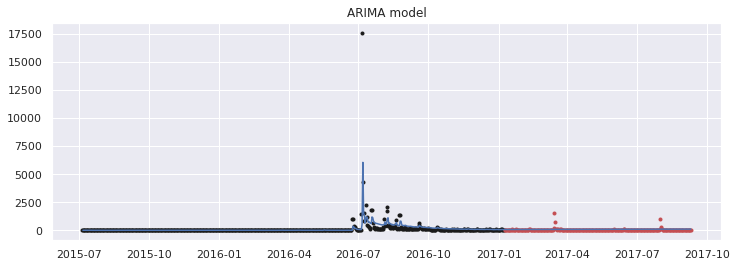

ROUND ... 6635/145063
The SMAPE score is : 0.76246
The RMSE score is : 132.82726


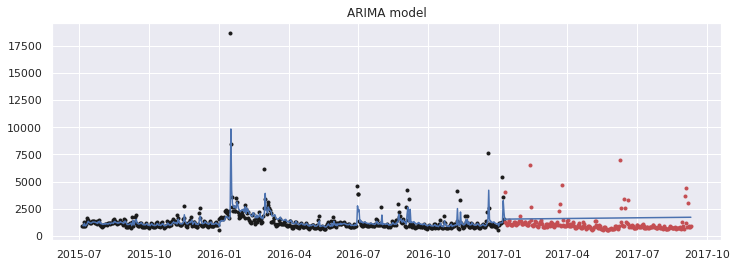

ROUND ... 99461/145063
The SMAPE score is : 0.57814
The RMSE score is : 953.64079


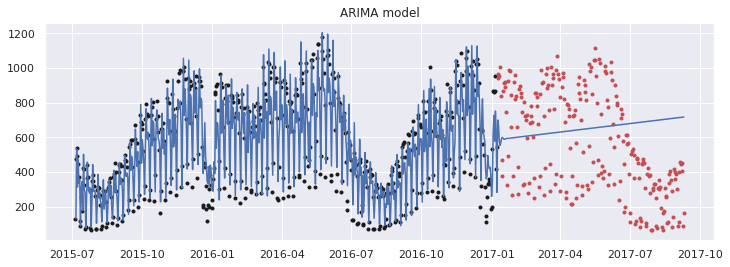

ROUND ... 5523/145063
The SMAPE score is : 0.53922
The RMSE score is : 326.36947


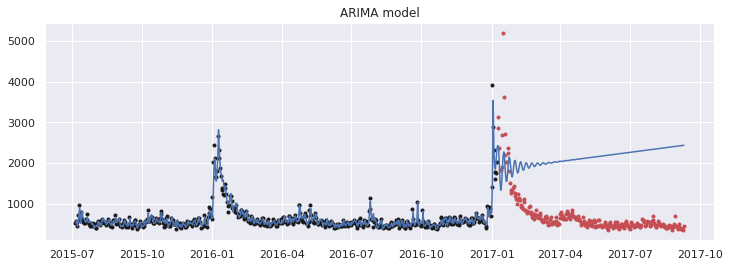

ROUND ... 71939/145063
The SMAPE score is : 1.07872
The RMSE score is : 1560.63414


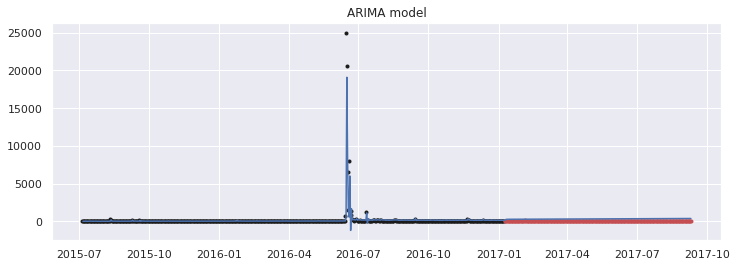

ROUND ... 121244/145063
The SMAPE score is : 1.67784
The RMSE score is : 307.11743


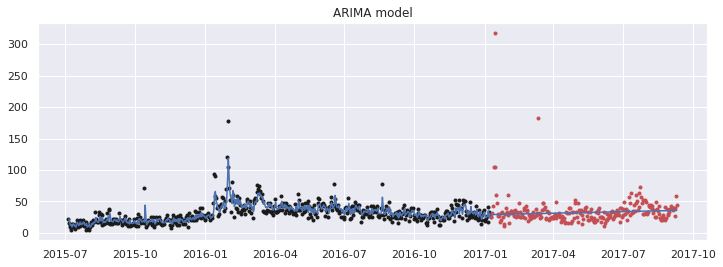

ROUND ... 80304/145063
The SMAPE score is : 0.26140
The RMSE score is : 24.08917


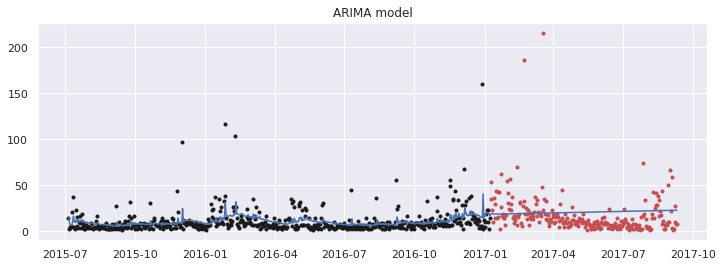

ROUND ... 142153/145063
The SMAPE score is : 0.74366
The RMSE score is : 22.14215


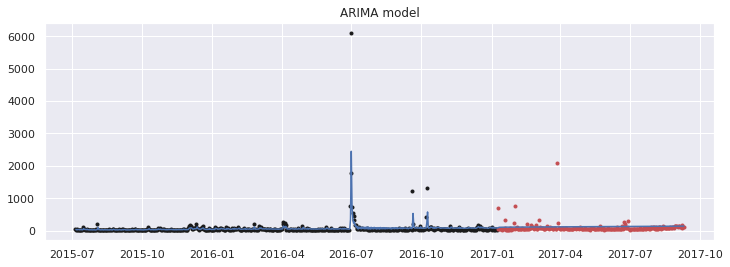

ROUND ... 34158/145063
The SMAPE score is : 0.65394
The RMSE score is : 153.55844


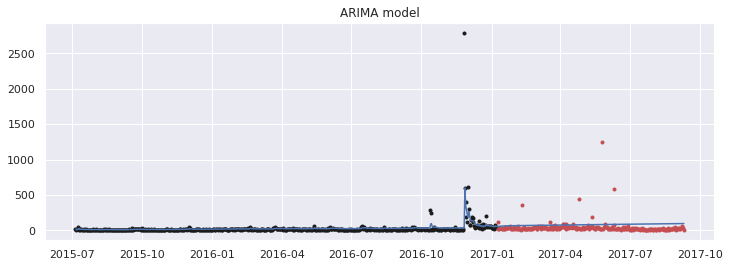

ROUND ... 129892/145063
The SMAPE score is : 0.96857
The RMSE score is : 102.25544


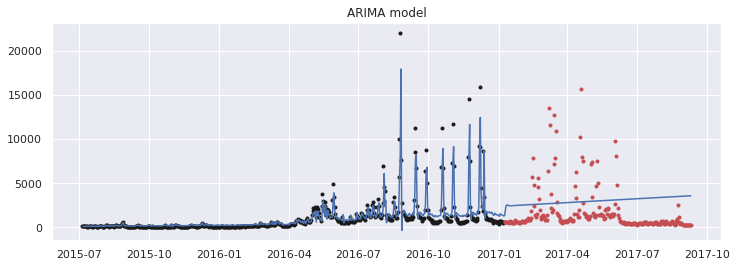

ROUND ... 70260/145063
The SMAPE score is : 1.09985
The RMSE score is : 2866.18704


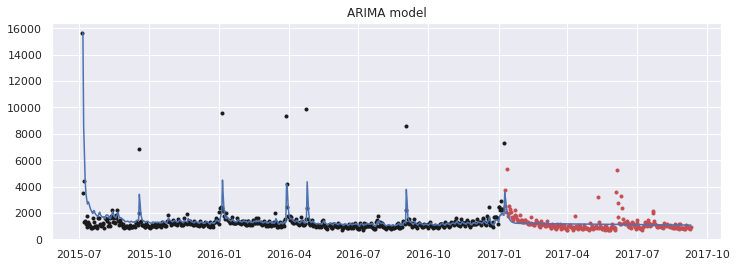

ROUND ... 140547/145063
The SMAPE score is : 0.21158
The RMSE score is : 515.34171


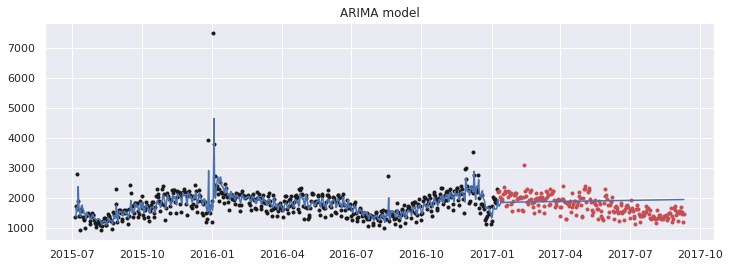

ROUND ... 139571/145063
The SMAPE score is : 0.17758
The RMSE score is : 372.43988


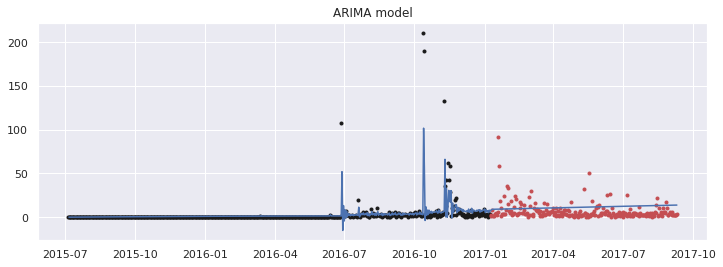

ROUND ... 130599/145063
The SMAPE score is : 0.97405
The RMSE score is : 10.80661


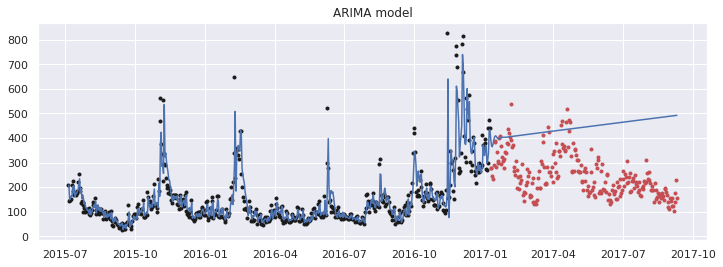

ROUND ... 107994/145063
The SMAPE score is : 0.60554
The RMSE score is : 221.22491


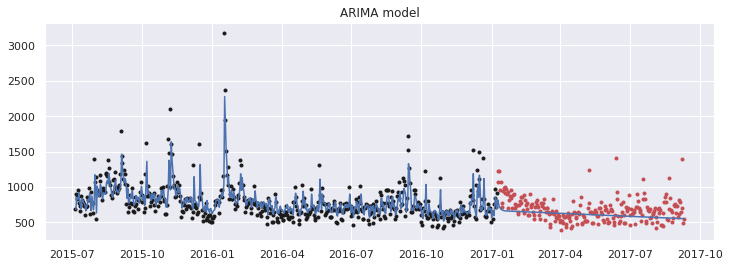

ROUND ... 85669/145063
The SMAPE score is : 0.17931
The RMSE score is : 172.66835


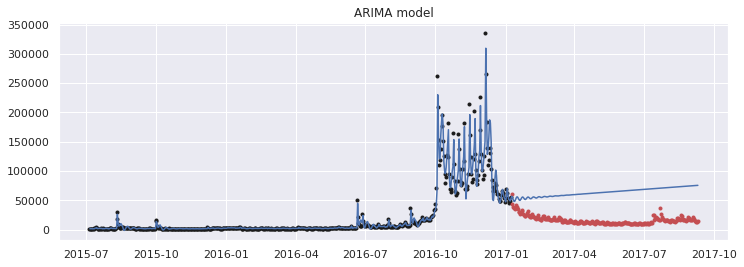

ROUND ... 39596/145063
The SMAPE score is : 1.18981
The RMSE score is : 48611.08636


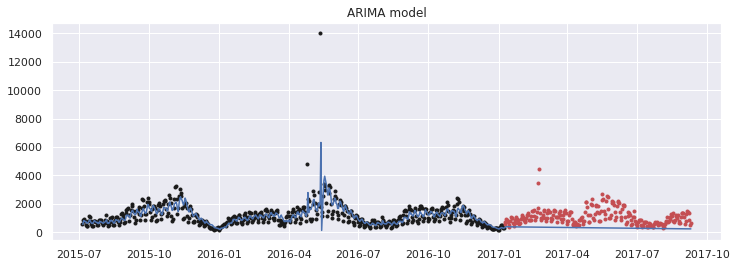

ROUND ... 69954/145063
The SMAPE score is : 1.00002
The RMSE score is : 953.10570


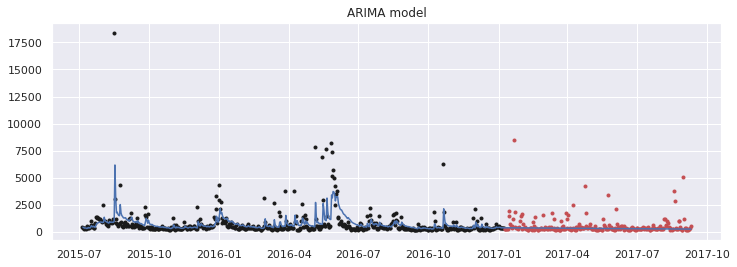

ROUND ... 114023/145063
The SMAPE score is : 0.41212
The RMSE score is : 835.24845


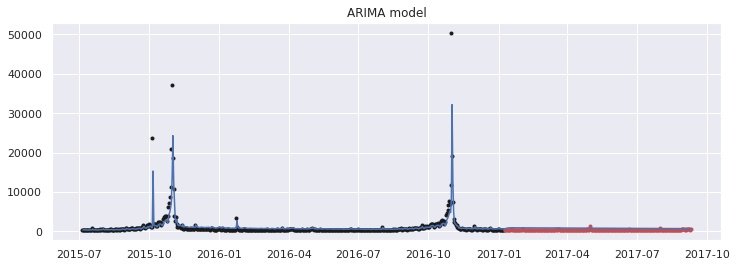

ROUND ... 10290/145063
The SMAPE score is : 0.70971
The RMSE score is : 434.10909


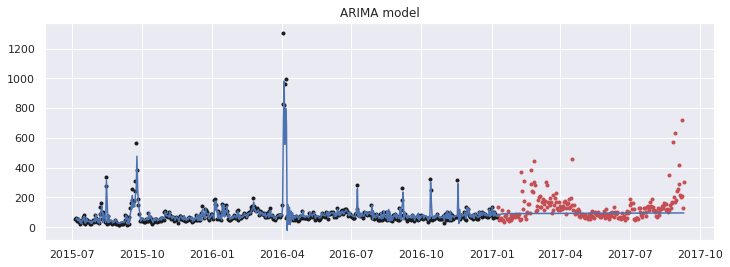

ROUND ... 35759/145063
The SMAPE score is : 0.39973
The RMSE score is : 99.13096


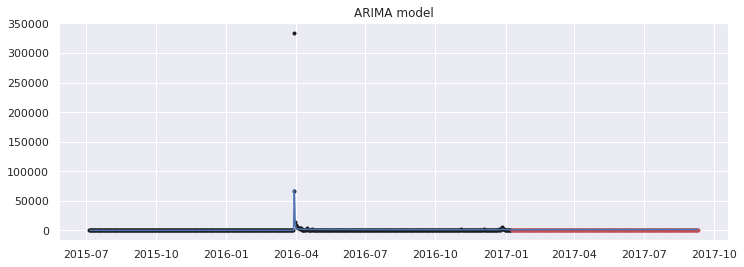

ROUND ... 66575/145063
The SMAPE score is : 1.42791
The RMSE score is : 1274.38185


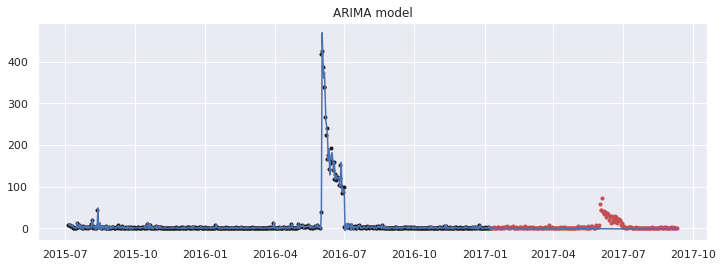

ROUND ... 79230/145063
The SMAPE score is : 1.74899
The RMSE score is : 11.93615


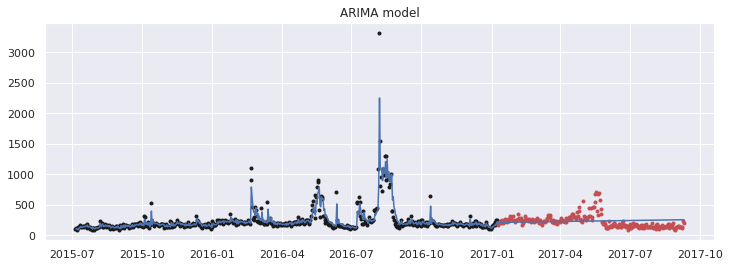

ROUND ... 17161/145063
The SMAPE score is : 0.34052
The RMSE score is : 108.69863


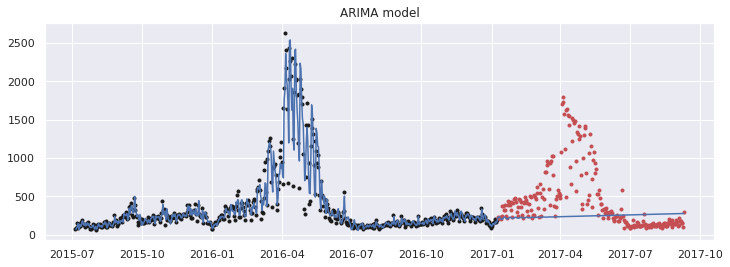

ROUND ... 103058/145063
The SMAPE score is : 0.67184
The RMSE score is : 466.66627


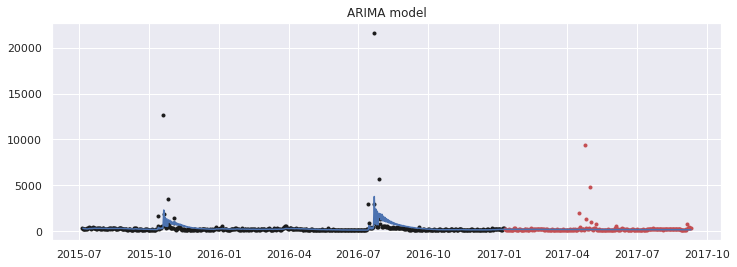

ROUND ... 53033/145063
The SMAPE score is : 0.26995
The RMSE score is : 682.35556


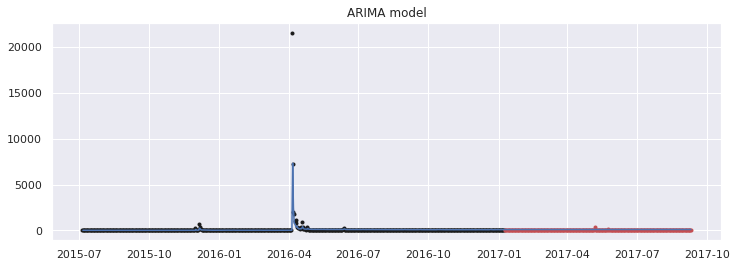

ROUND ... 25125/145063
The SMAPE score is : 1.44643
The RMSE score is : 87.20384
ALL DONE! 77 records with avg SMAPE score : 0.76020, and avg RMSE score : 252.58682


In [ ]:
# This is to demo the ARIMA model
# print(train.iloc[[2]])
sma_list = []
rms_list = []

for i in ran_sample:
  df_train = extract_series(X_train, i, 5)
  df_actual = extract_series(y_train, i, 5)
  # lang = X_train.iloc[i, 1]
  sma,rms= arima_model(df_train, df_actual, 2, 1, 2, review=True)
  print('ROUND ... ' + str(i) + '/' + str(len(X_train)))
  print("The SMAPE score is : %.5f" % sma)
  print("The RMSE score is : %.5f" % rms)
  if sma > 0 and rms > 0 and rms < 1000: 
    sma_list.append(sma)
    rms_list.append(rms)

print('ALL DONE! %d records with avg SMAPE score : %.5f, and avg RMSE score : %.5f' % (len(sma_list),sum(sma_list)/len(sma_list),sum(rms_list)/len(rms_list)))